In [1004]:
import numpy as np
import pandas as pd
import random

**Data Preprocessing** 

In [1005]:
#read in gage height file
readf = pd.read_csv(r'10yearsdata.csv')
waterrange = readf[:3561]
df1 = readf['Height'][:3561].copy()

In [1006]:
#read in weather file
weatherfile = pd.read_csv(r'weather.csv')

In [1007]:
weatherfile.loc[weatherfile['Date'] == '2013-10-23']

,Number,Date,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),Snow Depth (inches)
1391,1392,2013-10-23,39,33,0,0,0


In [1008]:
weatherfile = weatherfile[['Date','Precipitation (inches)']][1391:]

In [1009]:
#replace empty 'T' values with previous
weatherfile['Precipitation (inches)'] = weatherfile['Precipitation (inches)'].replace(to_replace='T',method='ffill') 
weatherfile['Precipitation (inches)'][0] = 0
weatherfile = weatherfile.reset_index(drop=True)

In [1010]:
#find missing dates, differences between the 2 arrays
date1 = readf['Date'].copy()
date2 = weatherfile['Date']
date2 = date2.reset_index(drop=True)
dt1 = date1.to_numpy()
dt2 = date2.to_numpy()
diff = np.setdiff1d(dt2, dt1)

In [1011]:
diff

array(['2021-11-09', '2021-11-10', '2021-11-11'], dtype=object)

In [1012]:
np.setdiff1d(dt1,dt2)

array(['2023-07-27', '2023-07-28', '2023-07-29', '2023-07-30',
       '2023-07-31', '2023-08-01', '2023-08-02', '2023-08-03',
       '2023-08-04'], dtype=object)

In [1013]:
weatherfile.loc[weatherfile['Date'] == '2021-11-09']

,Date,Precipitation (inches)
2939,2021-11-09,0


In [1014]:
df2 = weatherfile.drop([2939,2940,2941]) #drop precipitation rows to match missing dates in gage height data
dates = df2['Date']
dates = pd.to_datetime(dates)
df2 = df2['Precipitation (inches)']
df2 = df2.reset_index(drop=True)

In [1015]:
df1 = df1.reset_index(drop=True)

In [1016]:
#combine water level and precipitation into one dataframe
inputdata = pd.concat([df1,df2],axis=1)

In [1017]:
inputdata = inputdata.set_index(dates)

In [1018]:
inputdata.head()

,Height,Precipitation (inches)
Date,,
2013-10-23,3.473590,0
2013-10-24,3.472708,0
2013-10-25,3.512083,0
2013-10-26,3.363437,0
2013-10-27,3.445521,0


**Graphing initial data**

Text(0, 0.5, 'Water Level (inches)')

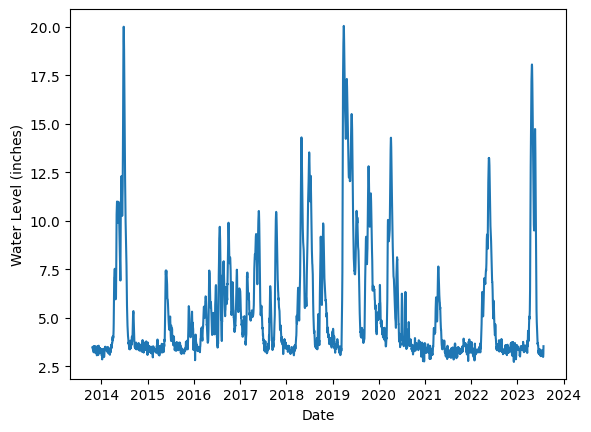

In [1019]:
plt.plot(inputdata['Height'])
plt.xlabel("Date")
plt.ylabel("Water Level (inches)")
#plt.plot(inputdata['Precipitation (inches)'][1:50])

In [1020]:
def split_years(dt, dates):
    dt['year'] = pd.DatetimeIndex(dates).year
    return [dt[dt['year'] == y] for y in dt['year'].unique()]

split = split_years(inputdata, dates)

In [1021]:
split = [split[i].reset_index(drop=True)['Height'] for i in range(len(split))]

In [1022]:
len(split)

11

In [1023]:
years = np.arange(2013,2024)
splitdf = pd.DataFrame(index=np.arange(366),columns=years)
for i in range(len(split)):
    splitdf[years[i]] = split[i]

In [1024]:
splitdf

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,3.473590,3.385833,3.281146,3.919062,6.406667,3.510833,4.298125,4.959583,3.652500,3.604271,3.549514
1,3.472708,3.280625,3.627813,4.049479,6.354479,3.511979,3.756875,5.458437,3.655104,3.484896,3.511597
2,3.512083,3.252708,3.727396,3.921771,6.213542,3.465625,3.761979,5.718021,3.669792,3.506771,3.474375
3,3.363437,3.050208,3.617396,3.822917,5.959167,3.437604,4.319375,5.552708,3.507500,3.612569,3.482500
4,3.445521,3.116354,3.291354,3.742917,5.595833,3.461146,4.427396,5.528958,3.440000,3.746632,3.421424
...,...,...,...,...,...,...,...,...,...,...,...
361,NaN,3.457604,3.862604,6.280625,3.724792,4.094688,4.905417,3.277292,3.540417,3.403507,NaN
362,NaN,3.260521,3.349896,6.231042,3.619479,3.997396,5.270729,3.675625,NaN,3.515243,NaN
363,NaN,3.260208,3.437292,6.358229,3.583021,3.881458,5.278437,3.689271,NaN,3.534167,NaN
364,NaN,3.090521,3.687604,6.436458,3.538021,4.305417,5.175937,3.614063,NaN,3.569375,NaN


In [1025]:
labels = splitdf.columns
labels = [str(i) for i in labels]

Text(0, 0.5, 'Water Level (inches)')

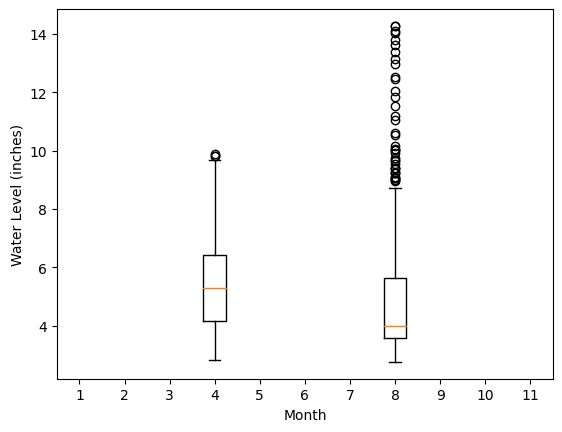

In [1026]:
plt.boxplot(splitdf)
plt.xlabel("Month")
plt.ylabel("Water Level (inches)")

In [1027]:
#shifts data into time steps to use for forecasting

def shift_series(data, n_in=1, n_out=1):
 n_vars = 1 if type(data) is pd.core.series.Series else data.shape[1] #amount of input variables
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # past time steps (t-n)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # future time steps (t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
         names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 agg = agg[agg.columns[::-1]]
 # remove rows with missing values
 agg.dropna(inplace=True)
 return agg

In [1028]:
n_days = 7 #time lags
n_features = 2 #features: past precipitation and water level
n_predict = 30 #days into the future

In [1029]:
data = shift_series(inputdata, n_days, n_predict)

In [1030]:
data

,var3(t+29),var2(t+29),var1(t+29),var3(t+28),var2(t+28),var1(t+28),var3(t+27),var2(t+27),var1(t+27),var3(t+26),...,var1(t-4),var3(t-5),var2(t-5),var1(t-5),var3(t-6),var2(t-6),var1(t-6),var3(t-7),var2(t-7),var1(t-7)
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-30,2013.0,0,3.349687,2013.0,0,3.336979,2013.0,0,3.070729,2013.0,...,3.363437,2013.0,0,3.512083,2013.0,0,3.472708,2013.0,0,3.473590
2013-10-31,2013.0,0,3.468646,2013.0,0,3.349687,2013.0,0,3.336979,2013.0,...,3.445521,2013.0,0,3.363437,2013.0,0,3.512083,2013.0,0,3.472708
2013-11-01,2013.0,0,3.476979,2013.0,0,3.468646,2013.0,0,3.349687,2013.0,...,3.502813,2013.0,0,3.445521,2013.0,0,3.363437,2013.0,0,3.512083
2013-11-02,2013.0,0,3.455104,2013.0,0,3.476979,2013.0,0,3.468646,2013.0,...,3.474375,2013.0,0,3.502813,2013.0,0,3.445521,2013.0,0,3.363437
2013-11-03,2013.0,0.12,3.481563,2013.0,0,3.455104,2013.0,0,3.476979,2013.0,...,3.394271,2013.0,0.03,3.474375,2013.0,0,3.502813,2013.0,0,3.445521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,2023.0,0,3.022465,2023.0,0.02,3.138819,2023.0,0,3.339583,2023.0,...,3.342083,2023.0,0.01,3.260729,2023.0,0,3.167604,2023.0,0,3.284722
2023-06-24,2023.0,0,2.987743,2023.0,0,3.022465,2023.0,0.02,3.138819,2023.0,...,3.287847,2023.0,0,3.342083,2023.0,0.01,3.260729,2023.0,0,3.167604
2023-06-25,2023.0,0.01,3.035521,2023.0,0,2.987743,2023.0,0,3.022465,2023.0,...,3.259097,2023.0,0,3.287847,2023.0,0,3.342083,2023.0,0.01,3.260729


In [ ]:
#NEW testing scale
from sklearn import preprocessing as prep
megascaler = prep.MinMaxScaler(feature_range=(0,1))
scaleddata = megascaler.fit_transform(np.array(data).reshape(-1,1))
scaleddata = scaleddata.reshape(3525,74)

In [ ]:
scaleddata = pd.DataFrame(scaleddata, columns=data.columns.values)

In [ ]:
input2 = scaleddata.loc[:, 'var2(t-1)': 'var1(t-7)']
output2 = scaleddata.loc[:, 'var1(t+29)': 'var1(t+29)':2]

In [ ]:
output2 = output2[output2.columns[::-1]]

In [1003]:
#split into train and test sets
end2 = len(scaleddata)-1
learnend2 = int(end2*0.9)
xtrain2 = input2[0:learnend2-1]
ytrain2 = output2[0:learnend2-1]
xtest2 = input2[learnend2:end2]
ytest2 = output2[learnend2:end2]

In [884]:
len(ytest2)

353

In [817]:
trainlength = xtrain2.shape[0]
testlength = xtest2.shape[0]
xrow = xtrain2.shape[1]
yrow = ytrain2.shape[1]

In [878]:
xtrain2.shape

(3170, 7, 2)

In [818]:
#reshape into 3D arrays [samples, timesteps, features]
xtrain2 = np.array(xtrain2).reshape((xtrain2.shape[0], n_days, n_features))
xtest2 = np.array(xtest2).reshape((xtest2.shape[0], n_days, n_features))

In [821]:
ytrain2 = np.array(ytrain2).reshape(trainlength,yrow)
ytest2 = np.array(ytest2).reshape(testlength,yrow)

In [846]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
#random seed to randomize model hyperparameters
seed = 2016
np.random.seed(seed)

#specifiy model
fit = Sequential()
fit.add(LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', input_shape=(xtrain2.shape[1], xtrain2.shape[2])))
#fit.add(LSTM(16, activation='tanh')) return_sequences=True, 
fit.add(Dense(1)) #output layer

In [847]:
fit.compile(loss="mean_squared_error", optimizer="adam") #adaptive learning rate

In [859]:
#fit the model
fit.fit(xtrain2, ytrain2, batch_size=64, epochs=20, shuffle=True)

Epoch 1/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 2/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 3/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 4/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 6/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 7/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 8/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 9/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 10/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 11/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 12/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 13/20
50/50 [==============================

In [860]:
#forecast
monthpred = fit.predict(xtest2)

12/12 [==============================] - 0s 1ms/step


In [861]:
#scale back to original values
yinv2 = megascaler.inverse_transform(np.array(monthpred).reshape(-1,1))

In [862]:
yinv2 = yinv2.reshape(testlength,yrow)

In [875]:
ans2 = megascaler.inverse_transform(np.array(ytest2).reshape(-1,1))

In [864]:
ans2 = ans2.reshape(testlength,yrow)

In [870]:
len(yinv2)

353

In [891]:
ans2 = ans2.reshape(1,-1)[0]

In [872]:
yinv2 = yinv2.reshape(1,-1)[0]

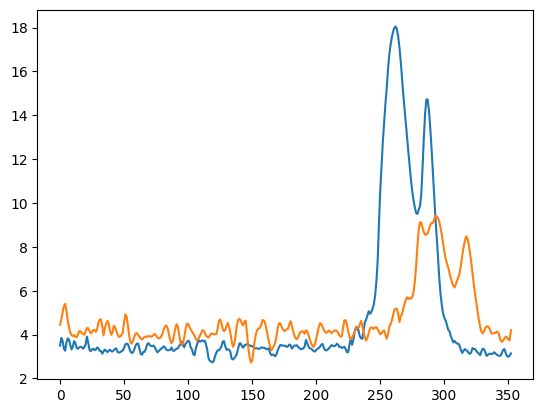

In [961]:
plt.plot(ans2)
plt.plot(yinv2)

In [892]:
ans2

array([ 3.49680147,  3.845     ,  3.71966667,  3.37231061,  3.265625  ,
        3.63774704,  3.82479839,  3.77736607,  3.52895161,  3.3230303 ,
        3.4559375 ,  3.70654167,  3.61767361,  3.38947581,  3.35871212,
        3.41970588,  3.44933628,  3.42690972,  3.3584375 ,  3.43975694,
        3.55736842,  3.91201923,  3.63176471,  3.30692857,  3.24203571,
        3.33275   ,  3.35665179,  3.29319444,  3.31435345,  3.41735577,
        3.37330882,  3.25820313,  3.24774194,  3.12935606,  3.234375  ,
        3.31818548,  3.26575   ,  3.20173387,  3.26506925,  3.31050691,
        3.24294118,  3.23168269,  3.28766129,  3.35819853,  3.36601852,
        3.20067308,  3.18224265,  3.19935185,  3.245625  ,  3.26975694,
        3.39506944,  3.54847222,  3.59118056,  3.56777778,  3.39854167,
        3.22653846,  3.1638676 ,  3.19385417,  3.32895833,  3.5025    ,
        3.5887218 ,  3.59159574,  3.36361111,  3.12829268,  3.08177083,
        3.21375   ,  3.21573529,  3.34947917,  3.55420139,  3.61

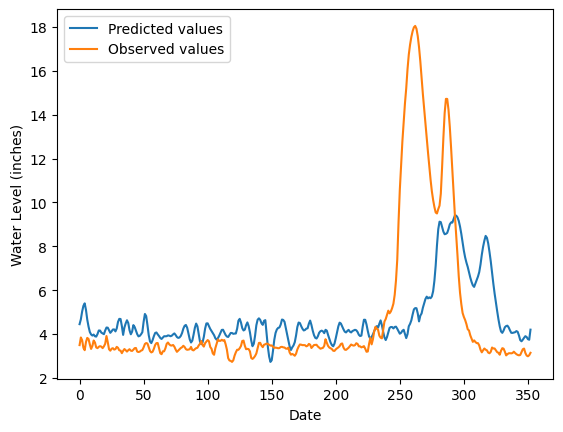

In [893]:
from matplotlib import pyplot as plt
n_year = 30
plt.plot(yinv2, label='Predicted values')
plt.plot(ans2, label='Observed values')
plt.xlabel("Date")
plt.ylabel("Water Level (inches)")
plt.legend()
plt.show()

In [990]:
from statsmodels.tsa.stattools import pacf, acf
x_pacf=pacf(inputdata['Height'], nlags=30, method='ols')

In [999]:
acorr = acf(inputdata['Height'], nlags=1000)

In [1002]:
acorr[:20]

array([1.        , 0.99563842, 0.98492529, 0.96945811, 0.9501602 ,
       0.92794723, 0.90374089, 0.87835565, 0.85245866, 0.82680999,
       0.80195029, 0.77818722, 0.75572242, 0.73456037, 0.71457287,
       0.6957031 , 0.67778728, 0.66061865, 0.64399645, 0.62767955])

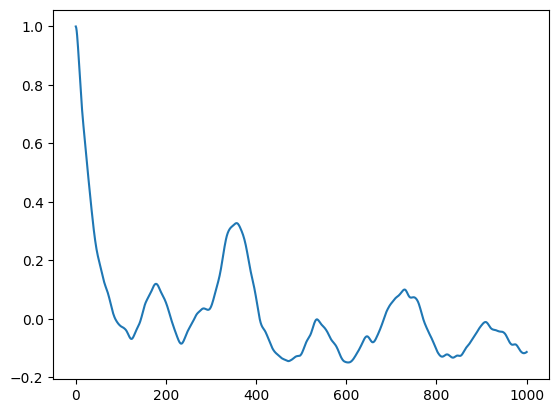

In [1000]:
plt.plot(acorr)

In [977]:
x_pacf[0:5]

array([ 1.        ,  0.99573998, -0.74777972, -0.0260564 , -0.0833911 ])

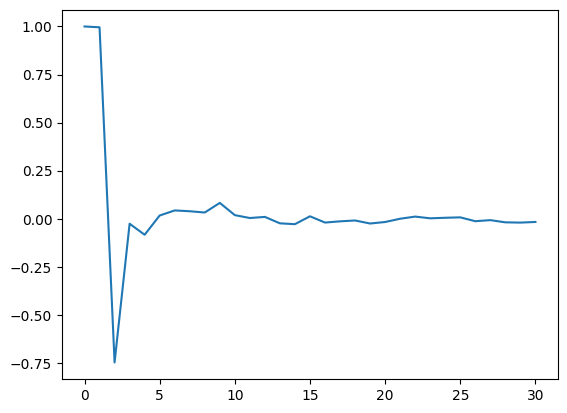

In [987]:
plt.plot(x_pacf)

In [886]:
import math
from sklearn.metrics import mean_squared_error as mse
eval = mse(ans2, yinv2)
math.sqrt(eval)

3.202412656605672

In [ ]:
TRIAL 2 - predict one month lead time

In [514]:
#separate input and output
output = data.loc[:, 'var1(t+29)'] 
input = data.loc[:, 'var2(t-1)': 'var1(t-3)']

In [515]:
output.head()

Date
2013-10-30    3.349687
2013-10-31    3.468646
2013-11-01    3.476979
2013-11-02    3.455104
2013-11-03    3.481563
Name: var1(t+29), dtype: float64

In [516]:
#split into train and test sets
end = len(data)-1
learnend = int(end*0.8)
xtrain = input[0:learnend-1]
ytrain = output[0:learnend-1]
xtest = input[learnend:end]
ytest = output[learnend:end]

In [517]:
xtrain.shape

(2818, 6)

In [518]:
xtest.shape

(705, 6)

In [519]:
ytrain.shape

(2818,)

In [520]:
ytest.shape

(705,)

In [521]:
from sklearn import preprocessing as prep
scaler1 = prep.MinMaxScaler(feature_range=(0,1))
xtrain = scaler1.fit_transform(np.array(xtrain).reshape(-1,1))
xtest = scaler1.transform(np.array(xtest).reshape(-1,1))
scaler2 = prep.MinMaxScaler(feature_range=(0,1))
ytrain = scaler2.fit_transform(np.array(ytrain).reshape(-1,1))
ytest = scaler2.transform(np.array(ytest).reshape(-1,1))

In [522]:
xtrain = xtrain.reshape(2818,6)
xtest = xtest.reshape(705,6)

In [524]:
#reshape into 3D arrays [samples, timesteps, features]
xtrain = xtrain.reshape((xtrain.shape[0], 3, n_features))
xtest = xtest.reshape((xtest.shape[0], 3, n_features))

In [525]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [526]:
#random seed to randomize model hyperparameters
seed = 2016
np.random.seed(seed)

#specifiy model
fit2 = Sequential()
fit2.add(LSTM(80, activation='tanh', recurrent_activation='hard_sigmoid', input_shape=(xtrain.shape[1], xtrain.shape[2])))
fit2.add(Dense(1, activation='linear')) #output layer

In [527]:
fit2.compile(loss="mean_squared_error", optimizer="rmsprop") #adaptive learning rate

In [528]:
#fit the model
fit2.fit(xtrain, ytrain, batch_size=64, epochs=20, shuffle=True)

Epoch 1/20
45/45 [==============================] - 1s 3ms/step - loss: 0.0259
Epoch 2/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 3/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 4/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 5/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 6/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 7/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 8/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 9/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 10/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 11/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 12/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 13/20
45/45 [==============================

In [529]:
#forecast
ypred = fit2.predict(xtest)

23/23 [==============================] - 0s 1ms/step


In [530]:
#scale back to original values
yinv = scaler2.inverse_transform(np.array(ypred).reshape(-1,1))

In [35]:
len(yinv)

699

In [37]:
len(ytest)

699

In [102]:
ytest

array([[0.0425189 ],
       [0.04104262],
       [0.04398627],
       ...,
       [0.03074685],
       [0.03535597],
       [0.03532988]])

In [531]:
ans = scaler2.inverse_transform(np.array(ytest).reshape(-1,1))
ans

array([[ 2.97875   ],
       [ 3.06010417],
       [ 3.145     ],
       [ 3.24333333],
       [ 3.22072917],
       [ 3.22197917],
       [ 3.29364583],
       [ 3.62395833],
       [ 3.671625  ],
       [ 3.40291667],
       [ 3.67395833],
       [ 3.198125  ],
       [ 3.1884375 ],
       [ 3.23510417],
       [ 3.28375   ],
       [ 3.32895833],
       [ 3.30697917],
       [ 3.44802083],
       [ 3.200625  ],
       [ 3.0425    ],
       [ 2.92395833],
       [ 3.06958333],
       [ 3.29978261],
       [ 3.434375  ],
       [ 3.29572917],
       [ 3.16458333],
       [ 2.97697917],
       [ 2.99052083],
       [ 3.20864583],
       [ 3.30115789],
       [ 3.40427083],
       [ 3.40104167],
       [ 3.4978125 ],
       [ 3.47947917],
       [ 3.32333333],
       [ 3.28916667],
       [ 3.26802083],
       [ 3.30916667],
       [ 3.42541667],
       [ 3.46958333],
       [ 3.38354167],
       [ 3.30645833],
       [ 3.27125   ],
       [ 3.33135417],
       [ 3.25920455],
       [ 3

In [533]:
ans = ans.reshape(705,)

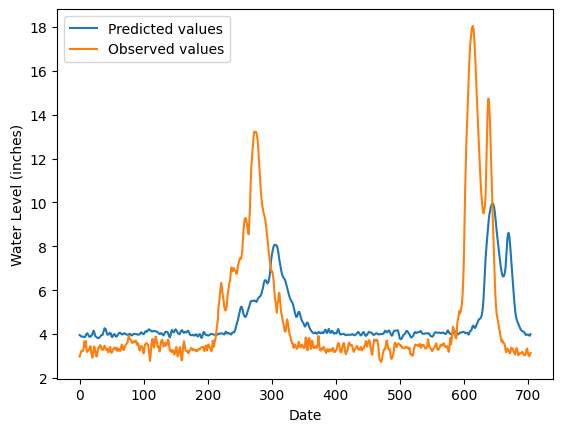

In [534]:
plt.plot(yinv, label='Predicted values')
plt.plot(ans, label='Observed values')
plt.xlabel("Date")
plt.ylabel("Water Level (inches)")
plt.legend()
plt.show()

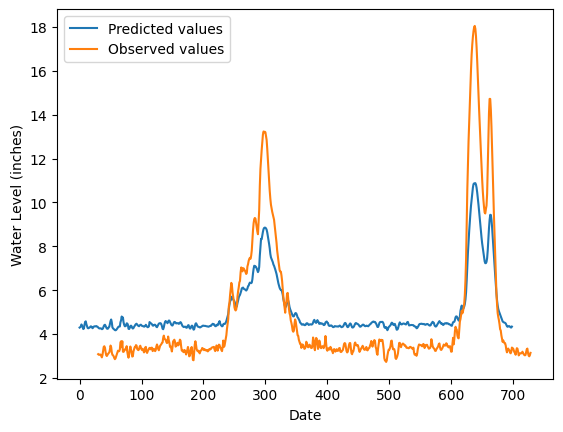

In [53]:

from matplotlib import pyplot as plt
plt.plot(yinv, label='Predicted values')
plt.plot(ans, label='Observed values')
plt.xlabel("Date")
plt.ylabel("Water Level (inches)")
plt.legend()
plt.show()

In [148]:
import math
from sklearn.metrics import mean_squared_error as mse

eval = mse(ans, yinv)
math.sqrt(eval)

3.005392998586383

In [833]:
eval

0.21698259414227472

Univariate model

In [282]:
seed = 2016
np.random.seed(seed)

#specifiy model
fit1 = Sequential()
fit1.add(LSTM(10, activation='tanh', recurrent_activation='hard_sigmoid', input_shape=(1083, 3)))
fit1.add(Dense(1, activation='linear')) #output layer

In [32]:
fit1.compile(loss="mean_squared_error", optimizer="rmsprop") #adaptive learning rate

In [56]:
fit1.fit(xtrain, ytrain, batch_size=1, epochs=10, shuffle=True)

Epoch 1/10
1088/1088 [==============================] - 2s 1ms/step - loss: 8.4175e-04
Epoch 2/10
1088/1088 [==============================] - 2s 1ms/step - loss: 6.3866e-04
Epoch 3/10
1088/1088 [==============================] - 2s 1ms/step - loss: 5.8158e-04
Epoch 4/10
1088/1088 [==============================] - 2s 1ms/step - loss: 5.4813e-04
Epoch 5/10
1088/1088 [==============================] - 2s 1ms/step - loss: 4.9125e-04
Epoch 6/10
1088/1088 [==============================] - 2s 1ms/step - loss: 4.7394e-04
Epoch 7/10
1088/1088 [==============================] - 2s 1ms/step - loss: 4.7502e-04
Epoch 8/10
1088/1088 [==============================] - 2s 1ms/step - loss: 4.6001e-04
Epoch 9/10
1088/1088 [==============================] - 2s 1ms/step - loss: 4.6106e-04
Epoch 10/10
1088/1088 [==============================] - 2s 1ms/step - loss: 4.6916e-04


In [396]:
ytest

0.03897122494593627

In [57]:
#mse
scoretrain = fit1.evaluate(xtrain, ytrain, batch_size=1)
scoretest = fit1.evaluate(xtest, ytest, batch_size=1)
print(scoretrain)
print(scoretest)

364/364 [==============================] - 0s 707us/step - loss: 0.0019
0.0005235161515884101
0.001888935687020421


In [58]:
#scale mse back to original data range
pred1 = fit1.predict(xtest)
pred1 = scalery.inverse_transform(np.array(pred1).reshape((len(pred1),1)))

12/12 [==============================] - 0s 952us/step


In [51]:
real = scalery.inverse_transform(ytest)

In [59]:
from sklearn.metrics import mean_squared_error as mse
mse(real, pred1)

0.4431970540386023

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pred1, label="prediction")
plt.plot(real, label="observed")
plt.show()
#add axes, units, legend